# Don't Be a Sucker
by Casey Durfee <csdurfee@gmail.com>

Copyright 2025. 

## Efficiency of Markets

The efficient market hypothesis says that markets are, given enough time and competition, able to establish the correct price for a commodity. In the case of sports betting, we could think of it as the price of a money line bet. If CLE -300 is a good value, people will rationally want to take it, driving the price up. If it is a bad value, people will rationally want to take the other side. The market maker will respond to an imbalance in bets by adjusting the price. These rational actors will collectively push the price towards the best possible estimate that humans can do.

Under this theory, the final lines should be more accurate than the opening lines. Are they? Indeed they are. Stats are from the NBA season, as of January 24th. I collected the data from sportsbookreview.com [TODO link]

### Caveats
This is an analysis of the MGM Grand's NBA lines for 2025. It's not a comprehensive guide to how the lines work. Some of this year's trends appear to be very different from previous seasons.

There are always two lines on each game, one for the home team and one for the away team. Each side may have different vigs. Say for instance Bucks @ Pacers starts out at IND +3.5 -110/MIL -3.5 -110. It could close at IND +3.5 -115/MIL -3.5 -110. So it costs more to bet on the Pacers, but the actual line didn't move.  I'm mostly ignoring that for now.

In [1]:
import scrape_sbr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from win_loss_report import win_loss_report, win_loss_from_df

In [2]:
game_data = scrape_sbr.clean_data(end="2025-01-24")

missing scores from 2 games


### MGM quirk: avoiding pushes

When the final score agrees with the line exactly, neither side of the bet can be declared a winner. This is called a push. the bet is cancelled and everybody gets their money back.

The MGM Grand's policy seems to be to never offer bets that can push. Every single closing line in the data I have ends with a .5.

In [37]:
len(game_data) == sum(game_data.away_spread.astype(str).str.endswith(".5"))

True

My code calculates difference between the final score and the line, called the error.  The smaller the difference between the prediction and reality, the better the prediction. Mean Squared Error is a standard way to compare two prediction systems. 

Because the lines always end in a half point, that means the error is going to be artificially high -- there will never be a game where it is exactly zero.

In [3]:
opening_errors = game_data.open_with_line.to_numpy()
closing_errors = game_data.with_line.to_numpy()

In [4]:
(opening_errors ** 2).mean()

np.float64(188.30263157894737)

In [5]:
(closing_errors ** 2).mean()

np.float64(181.9046052631579)

The closing lines do have lower MSE than the opening lines. In aggregate, the betting market does "know" a little bit more about basketball than the handicappers creating the original lines.

Let's look at how far the lines were off by. the X's are the closing lines, the Os are the opening lines. If the X is closer to the center line than the O, the market action made the line more accurate.

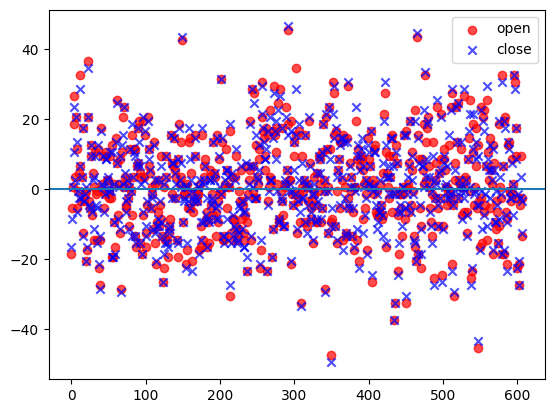

In [6]:
plt.scatter(range(len(opening_errors)), opening_errors, color='r', alpha=0.7, label="open")
plt.scatter(range(len(closing_errors)), closing_errors, color='b',alpha=0.7, marker="x", label="close")
plt.legend()
plt.axhline(y=0)

### Adam Smith, Handicapper

How often were the closing lines were more accurate than the opening lines?

In [7]:
print("Closing lines better:\t", sum(abs(opening_errors) > abs(closing_errors)))
print("Opening lines better:\t", sum(abs(opening_errors) < abs(closing_errors)))
print("Tied:\t\t\t", sum(abs(opening_errors) == abs(closing_errors)))


Closing lines better:	 238
Opening lines better:	 197
Tied:			 173


If the free market were a handicapper, and we interpreted the line movements as a bet on one side, they would have a 54.7% winning percentage.

In [8]:
win_loss_report(238, 197)

record:   238 - 197
full vig (-110) units: 21.3
reduced juice (-106) : 29.18
reduced juice (-105) : 31.15
betting market       : 30.51
win pct: 54.71%, expected wins: 217.5
excess: 20.5, profit %: 4.9
z test: 1.97, std: 10.43 , p-value: 0.0247


While that's OK for a human trying to beat the spread, I was expecting better from the free market. The market only being right 55% of the time holds true for previous seasons I have looked at as well. (Why is it wrong 45% of the time? What can be learned from those games? That's a question for another day.)

I'm curious about the 173 games where the spread didn't change. Maybe those lines were perfect as-is? If so, we'd expect to see equal splits of home vs. away winners, and underdog vs. favorite winners.  There shouldn't be any bias to the errors in these games. The free market is essentially labelling these the pinnacle of the handicapper's art.

In [9]:
tie_games = game_data.loc[abs(opening_errors) == abs(closing_errors), :]
tie_games.winner_ats.value_counts()

winner_ats
AWAY    92
HOME    81
Name: count, dtype: int64

In [10]:
tie_games.fave_dog.value_counts()

fave_dog
DOG     100
FAVE     73
Name: count, dtype: int64

There's a slight bias towards away teams and a significant bias towards underdogs winning those bets. I have looked at data from a few previous years, and this bias did not exist. In the past, lines that don't move are split roughly 50/50 between home/away and favorite/underdog.

Someone taking the underdog in every game where the line didn't move would go 100-73 this season. Now that's an impressive record. 

In [11]:
win_loss_report(100,73)

record:   100 - 73
full vig (-110) units: 19.7
reduced juice (-106) : 22.62
reduced juice (-105) : 23.35
betting market       : 22.76
win pct: 57.8%, expected wins: 86.5
excess: 13.5, profit %: 11.39
z test: 2.05, std: 6.58 , p-value: 0.02


Seems like the free market is leaving a lot of meat on the bone.

### Being careful with the vig

In a fair world, we would expect the side with the higher vig to win more often. Moving the vig from -110 to -115 is a way for the bookmaker to encourage bets on the other side without moving the line. Likewise moving it to -105 is a way to encourage bets on that side.

Since the MGM Grand always keeps their line on the half point, we'd expect them to do this often. They do for most of these games, but 41% of the time the vig stays at -110.

In [12]:
highvig = tie_games[tie_games.away_vig.abs() > 110]
lowvig = tie_games[tie_games.away_vig.abs() < 110]
medvig = tie_games[tie_games.away_vig.abs() == 110]


print(f"========high vig ({len(highvig)})\n{highvig.fave_dog.value_counts()}")
print(f"========standard vig ({len(medvig)})\n\n{medvig.fave_dog.value_counts()}")
print(f"========low vig ({len(lowvig)})\n\n{lowvig.fave_dog.value_counts()}")


========high vig (53)
fave_dog
DOG     36
FAVE    17
Name: count, dtype: int64
========standard vig (72)

fave_dog
DOG     38
FAVE    34
Name: count, dtype: int64
========low vig (48)

fave_dog
DOG     26
FAVE    22
Name: count, dtype: int64


In [13]:
72/ (53 + 72 + 48)

0.4161849710982659

However, with a 36-17 record on the high vig games, the higher -115 vig doesn't affect the number of units won that much, only dropping from 17.3 to 16.45.

In [14]:
win_loss_report(36,17, vig=1.10)
print("=" * 30)
win_loss_report(36,17, vig=1.15)

record:   36 - 17
full vig (-110) units: 17.3
reduced juice (-106) : 17.98
reduced juice (-105) : 18.15
betting market       : 17.63
win pct: 67.92%, expected wins: 26.5
excess: 9.5, profit %: 32.64
z test: 2.61, std: 3.64 , p-value: 0.0045
record:   36 - 17
actual (1.15 vig) units: 16.45
full vig (-110) units: 17.3
reduced juice (-106) : 17.98
reduced juice (-105) : 18.15
betting market       : 17.63
win pct: 67.92%, expected wins: 26.5
excess: 9.5, profit %: 31.04
z test: 2.61, std: 3.64 , p-value: 0.0045


This feels like a legitimate betting angle: bet the underdog when the MGM line doesn't move.

### Underdogs and Aways

In general, betting the underdog has been the better strategy this season.

In [15]:
game_data.fave_dog.value_counts()

fave_dog
DOG     318
FAVE    290
Name: count, dtype: int64

In [16]:
win_loss_report(318,290)

record:   318 - 290
full vig (-110) units: -1.0
reduced juice (-106) : 10.6
reduced juice (-105) : 13.5
betting market       : 13.53
win pct: 52.3%, expected wins: 304.0
excess: 14.0, profit %: -0.16
z test: 1.14, std: 12.33 , p-value: 0.1281


Underdogs win about 52.4% of the time this season so far. You've seen that number before, remember? That's the break-even point when betting -110. In other words, a gambler would lose 1 unit taking all 600+ underdogs this season, and up over 10 units on reduced juice.

They would lose 60 units betting on every favorite:

In [17]:
win_loss_report(290,318)

record:   290 - 318
full vig (-110) units: -59.8
reduced juice (-106) : -47.08
reduced juice (-105) : -43.9
betting market       : -42.11
win pct: 47.7%, expected wins: 304.0
excess: -14.0, profit %: -9.84
z test: -1.14, std: 12.33 , p-value: 0.8719


Underdogs did well early, winning about 55% of the time against the spread in the first 300 games of the season.

In [18]:
first_quarter_of_season = game_data.loc[:300,:]
second_quarter_of_season = game_data.loc[300:,:]

first_quarter_of_season.fave_dog.value_counts()

fave_dog
DOG     165
FAVE    136
Name: count, dtype: int64

They have been roughly equal since then:

In [19]:
second_quarter_of_season.fave_dog.value_counts()

fave_dog
FAVE    155
DOG     153
Name: count, dtype: int64

The slight bias towards away teams is more consistent, but smaller.

In [20]:
first_quarter_of_season.winner_ats.value_counts()

winner_ats
AWAY    156
HOME    145
Name: count, dtype: int64

In [21]:
second_quarter_of_season.winner_ats.value_counts()

winner_ats
AWAY    160
HOME    148
Name: count, dtype: int64

Just taking the away teams would lose a gamber -6.3 units at full vig, and make them 8.35 units at -105 vig.

In [22]:
win_loss_report(156+160, 145+148)

record:   316 - 293
full vig (-110) units: -6.3
reduced juice (-106) : 5.42
reduced juice (-105) : 8.35
betting market       : 8.54
win pct: 51.89%, expected wins: 304.5
excess: 11.5, profit %: -1.03
z test: 0.93, std: 12.34 , p-value: 0.1757


### Are the lines improving over the course of the season?

I was curious if there was evidence that the errors were getting smaller, or more predictable over time.

The raw errors are too noisy to see much of a pattern. 

Text(0.5, 0, 'game number')

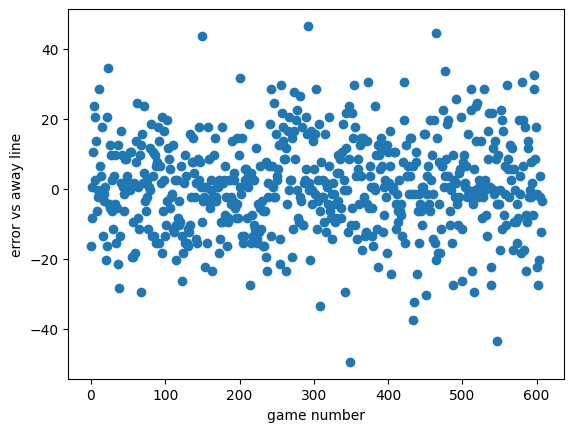

In [56]:
abs_closing_errors = np.abs(closing_errors)
plt.scatter(range(len(closing_errors)), closing_errors)
plt.ylabel("error vs away line")
plt.xlabel("game number")

Moving average is a way to bring any patterns out, but the window size is totally arbitrary. I'm using 50 games, which is about a week's worth of games.

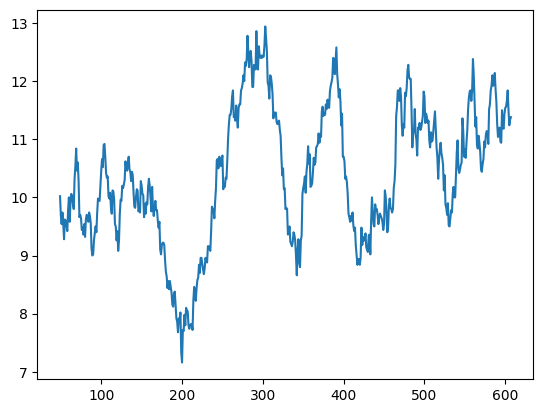

In [24]:
closing_ma = pd.Series(abs_closing_errors).rolling(window=50).mean()
plt.plot(closing_ma)

I was curious about the period of time where the errors dipped, which was around November 10th. I didn't find anything significant. The games were just closer than usual relative to the line. There were some NBA Cup games, which were more competitive than early November games usually are. So, there might be something there.

Here is a moving average of the magnitude of the lines. It's sort of a measure of how close the games are predicted to be on average.

The lines appear to be getting bigger over the past couple of weeks, perhaps because many teams are actively trying to get worse to get the best draft pick possible this year. So games between good and bad teams aren't as competitive as the start of the season. 

The top prospect in this year's draft is Cooper Flagg, so this process has been known as "Capture the Flagg". It could also just a quirk of the schedule - a lot of really good teams playing really bad teams right now.

In [25]:
spread_abs_ma = pd.Series(game_data.away_spread.abs()).rolling(window=50).mean()

<Axes: >

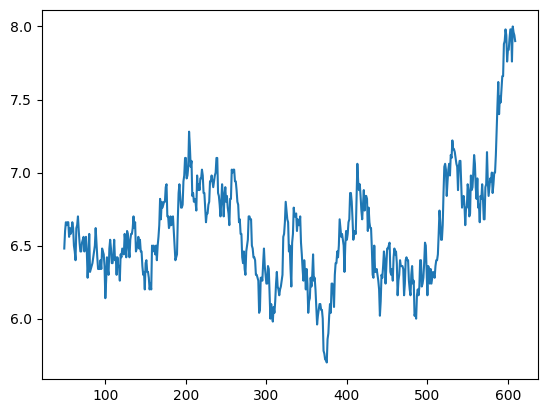

In [26]:
spread_abs_ma.plot()

The absolute error isn't as significant as the relative error. Being off by 2 points on a 1 point line is a much bigger deal than being off by 2 points on a 15 point line.

Below, I'm plotting the ratio of the error to the original spread. Because of outliers, I'm using the median value.

This is a little hacky. A better approach would be to convert the error to how far the probability was off by.

1.4824242424242424


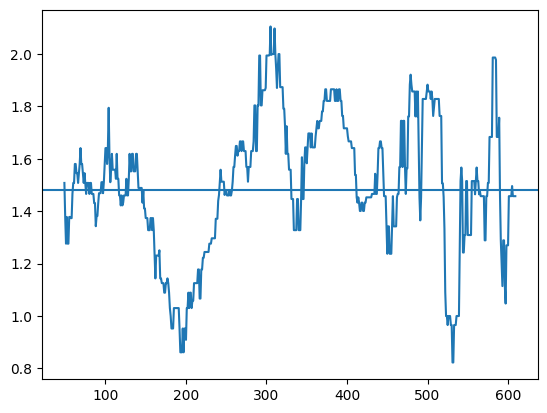

In [58]:
error_ratio = abs_closing_errors / game_data.away_spread.abs()
median_ratio  = np.median(error_ratio)

plt.plot(pd.Series(error_ratio).rolling(window=50).median())
plt.axhline(y=median_ratio)

On the surface, it seems bad to be off by a factor of 1.5x or more most of the time. But the handicapper's job isn't to predict the range of possible outcomes, just the expected value, or weighted average, of all outcomes. The above graph is essentially showing the dispersion (*how variable* the data is).

I don't see clear evidence that the lines are getting better as the season goes on. I was expecting lines to be worse at the beginnning of the season, improving over time as more data about each team is available. More data should mean better predictions.

It's probably more fruitful to look at games that ended up close to the line. These are the ones where they make their money, so to speak. Are there any biases?

### What games are affected by line movement?

There are 67 games where the winner flipped from the favorite to the dog, or the dog to the favorite, because of the line movement. In other words, these are games where either side could have won the bet, depending on whether you took the opening line or the closing line.

In [28]:
movers = game_data[game_data.fave_dog != game_data.open_fave_dog]

In these games, a roughly equal number of favorites and dogs won against the final lines. So that seems pretty balanced.

In [29]:
movers.fave_dog.value_counts()

fave_dog
FAVE    34
DOG     33
Name: count, dtype: int64

What about games where the line was very close? Are there any patterns?

In [35]:
close_games = game_data[game_data.with_line.abs() < 3]
close_games.fave_dog.value_counts() / len(close_games.fave_dog)

fave_dog
DOG     0.541667
FAVE    0.458333
Name: count, dtype: float64

Underdogs win games where the line was off by less than 3 points 54% of the time.

That's not significant, but if we look at games where the line was off by 1 point or less, the underdogs win 70% of the time.

In [31]:
super_close = game_data[game_data.with_line.abs() <= 1]
super_close.fave_dog.value_counts()

fave_dog
DOG     35
FAVE    15
Name: count, dtype: int64

While not a large sample size, 70% is surprising.

I showed above that underdogs went 318-290. That would net +13.5 units profit at -105 juice. This would net 19.25 profit. So all of the profit (and then some) comes from these 50 games.

Of course, there's no way to identify these games before they happen!

In [60]:
win_loss_report(35,15)

record:   35 - 15
full vig (-110) units: 18.5
reduced juice (-106) : 19.1
reduced juice (-105) : 19.25
betting market       : 18.69
win pct: 70.0%, expected wins: 25.0
excess: 10.0, profit %: 37.0
z test: 2.83, std: 3.54 , p-value: 0.0023


In [61]:
win_loss_report(318,290)

record:   318 - 290
full vig (-110) units: -1.0
reduced juice (-106) : 10.6
reduced juice (-105) : 13.5
betting market       : 13.53
win pct: 52.3%, expected wins: 304.0
excess: 14.0, profit %: -0.16
z test: 1.14, std: 12.33 , p-value: 0.1281



### What would "perfect" lines look like?


It's rare to see NBA lines that are bigger than +15/-15 points. there have only been 15 this season, about 2.5% of all games. That's about one NBA game a week with a line that high.

In [52]:
sum(game_data.away_spread.abs() > 15) / len(game_data)

0.024671052631578948

By contrast, 29% of NBA games end with a score differential of over 15 points.

There are about 7 games a day in the NBA season, so that's around 2 games a day, or 14 games a week.

In [51]:
sum(abs(game_data.score_diff) > 15) / len(game_data)

0.2878289473684211

Here's a plot of the original line (X axis) versus the error. there are no lines at exactly zero. The dots to the left are games where the away team was favored, and the right where they were underdogs.  There is more density on the right because the away team is usually the underdog.

In [92]:
print(f"away underdogs: {sum(game_data.away_spread > 0)}")
print(f"away favorites: {sum(game_data.away_spread < 0)}")


away underdogs: 371
away favorites: 237


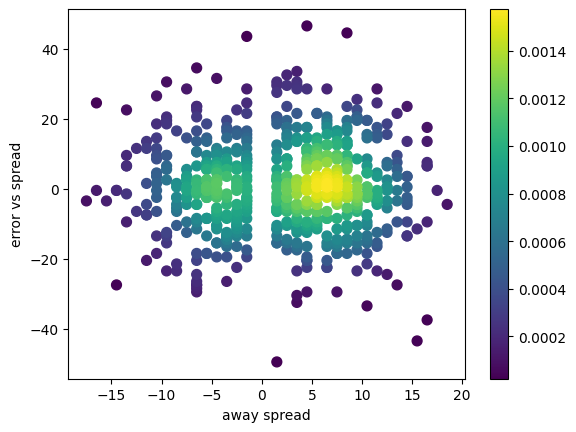

In [157]:
from scipy.stats import gaussian_kde

def density_scatter_plot(x,y, x_label, y_label):
    # following cribbed from https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    #fig, ax = plt.subplots()
    plt.scatter(x, y, c=z, s=50)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.colorbar()

    plt.show()

away_spread = game_data.away_spread.to_numpy()
err_vs_spread = game_data.with_line.to_numpy()
density_scatter_plot(away_spread, err_vs_spread, "away spread", "error vs spread")

Here's a plot of the spread versus the final score differential (from the perspective of the away team). The final differential is much more dispersed than the spreads.

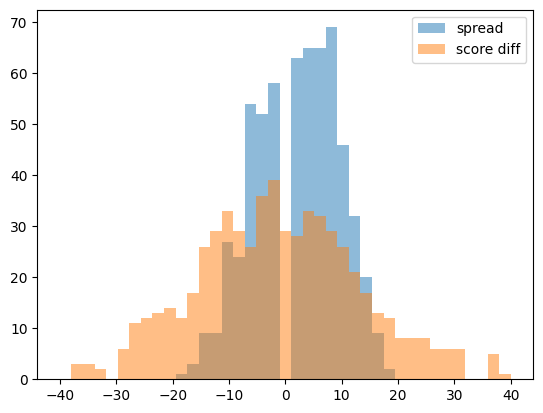

In [93]:
score_diff = game_data.score_diff.to_numpy()

bins = np.linspace(-40, 40, 40)

plt.hist(away_spread, bins, alpha=0.5, label='spread')
plt.hist(score_diff, bins, alpha=0.5, label='score diff')
plt.legend(loc='upper right')
plt.show()


This is approximating a normal distribution to match the histogram.

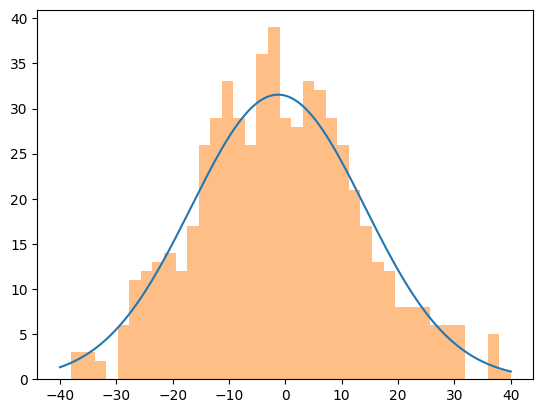

In [142]:
sample_variance  = np.var(score_diff)
sample_mean = np.mean(score_diff)
sample_sd = np.sqrt(sample_variance)


x = np.linspace(-40,40,200)
hist_x = np.linspace(-40,40,40)

bin_width = 2
fudge_factor = len(score_diff) * bin_width # to make the AUC of normal distribution match AUC of histogram

plt.plot(x, fudge_factor * scipy.stats.norm.pdf(x, sample_mean, sample_sd))
out = plt.hist(score_diff, hist_x, alpha=0.5, label='score diff')


It looks pretty normal. But the problem is, these aren't outcomes from one distribution. Every game is a sample from a different distribution. Each one has a different mean (the line) and a different variance (how predictable games are between the two teams). That ends up looking kind of normal. Let's simulate that.

TODO: make this visualization better.

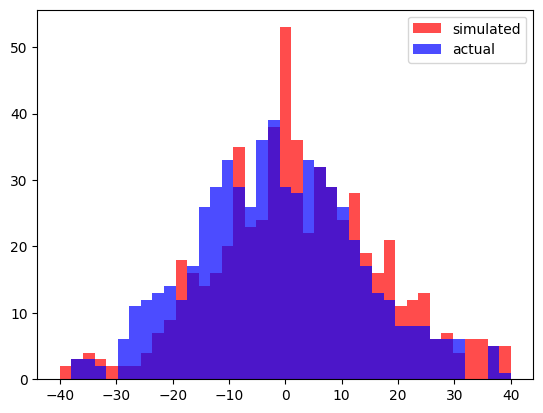

In [156]:
# for each line, simulate a distribution of outcomes with the poisson? or get variance 

sample_variance_by_spread = game_data.groupby('away_spread')['score_diff'].agg('var').dropna()

sample_outputs = []

for i, row in game_data.iterrows():
    this_line = row.away_spread
    #print(f"this line is {this_line}")
    if this_line in sample_variance_by_spread:
        sample_sd = np.sqrt(sample_variance_by_spread[this_line])

        # simulate each game by sampling from a normal distribution with 
        
        simulation = scipy.stats.norm.rvs(loc=this_line, scale=sample_sd)

        # the problem with 'round' here is that it will make some games end in a tie!
        # any number in simulation that would be at zero, we round away from zero
        if (simulation < 0) and (simulation > -1):
            round_sim = -1
        elif (simulation > 0) and (simulation < 1):
            round_sim = 1
        else:
            round_sim = round(simulation)

        sample_outputs.append(round_sim)
    
plt.hist(sample_outputs, hist_x, alpha=0.7, label='simulated', color='r')
plt.hist(score_diff, hist_x, alpha=0.7, label='actual', color='b')
_output = plt.legend(loc='upper right')


I know that's a pretty rough simulation. but hopefully it shows that the lines shouldn't be bigger, even though they are frequently off by many multiples. If the line is Dallas -3 and the other team wins by 27, that doesn't mean the line was off by 30 points.

The lines represent the mid-way point of a range of outcomes. The handicapper doesn't really need to know the shape of that distribution. There's only one number to estimate, the average outcome, if we could rewind time and have the teams play over and over again.

### Conclusions
While the market is semi-efficient, it isn't perfect. It's hard to estimate how imperfect it is because we only get one sample of each game. But there seems to be a bit of a bias towards underdogs with the MGM lines this season, particularly in games where the line doesn't move.
